# UTS: Klasifikasi Teks Berita dengan LDA Feature Extraction dan SVM dan Naive Bayes

Tugas ini bertujuan untuk melakukan **Klasifikasi Teks Berita** menggunakan:
- **LDA (Latent Dirichlet Allocation)** sebagai metode ekstraksi fitur
- **SVM (Support Vector Machine)** sebagai algoritma klasifikasi

## Tahapan Pengerjaan:
1. **Persiapan Data Berlabel** - Load dan split data training/testing
2. **Pra-pemrosesan Teks** - Data sudah di-preprocessing (kolom `stemming_indo`)
3. **Ekstraksi Fitur dengan LDA** - Transform teks menjadi distribusi topik
4. **Pelatihan Model SVM** - Latih classifier dengan fitur LDA
5. **Evaluasi Hasil** - Ukur performa dan bandingkan dengan TF-IDF

## 1. Import Libraries

In [6]:
# Import libraries untuk data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import libraries untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries untuk text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Import LDA
from sklearn.decomposition import LatentDirichletAllocation

# Import SVM dan metrics
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, classification_report, confusion_matrix)

# Import untuk grid search
from sklearn.model_selection import GridSearchCV

print("✓ Libraries berhasil di-import")

✓ Libraries berhasil di-import


## 2. Load dan Eksplorasi Data

In [7]:
# Load dataset
df = pd.read_csv('datasets/preprocessing_berita.csv')

# Tampilkan info dataset
print("="*50)
print("INFORMASI DATASET")
print("="*50)
print(f"Jumlah data: {len(df)}")
print(f"Jumlah kolom: {len(df.columns)}")
print(f"\nKolom-kolom:")
print(df.columns.tolist())

# Tampilkan beberapa baris pertama
print("\n" + "="*50)
print("5 BARIS PERTAMA DATA")
print("="*50)
df.head()

INFORMASI DATASET
Jumlah data: 1500
Jumlah kolom: 3

Kolom-kolom:
['berita', 'kategori', 'clean']

5 BARIS PERTAMA DATA


,berita,kategori,clean
0,Menteri Koordinator (Menko) Bidang Perekonomia...,Ekonomi,menteri koordinator menko bidang ekonomi airla...
1,"Dalam rangka memeriahkan hari jadi ke-50, PT S...",Ekonomi,rangka riah pt surabaya industrial estate rung...
2,Wacana Presiden Prabowo Subianto akan membentu...,Ekonomi,wacana presiden prabowo subianto bentuk bentuk...
3,BPJS Ketenagakerjaan dan Kementerian Agama (Ke...,Ekonomi,bpjs ketenagakerjaan menteri agama kemenag lin...
4,Pemerintah akan segera membentuk Satuan Tugas ...,Ekonomi,perintah bentuk satu tugas putus hubung kerja ...


DISTRIBUSI KATEGORI BERITA
kategori
Ekonomi          375
Olahraga         375
Nasional         375
Internasional    375
Name: count, dtype: int64


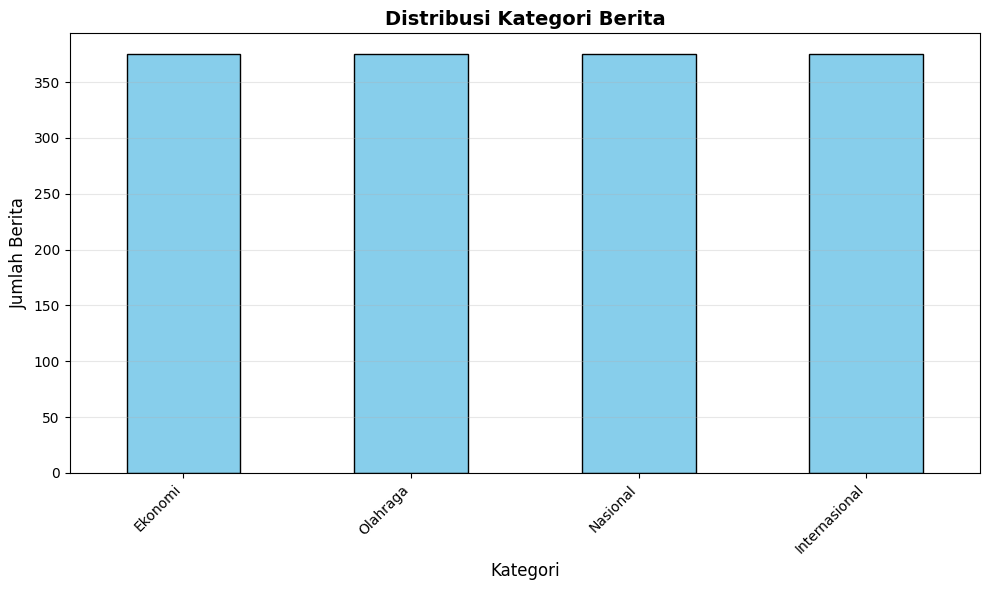


Jumlah kategori: 4


In [8]:
# Cek distribusi kategori berita
print("="*50)
print("DISTRIBUSI KATEGORI BERITA")
print("="*50)
kategori_dist = df['kategori'].value_counts()
print(kategori_dist)

# Visualisasi distribusi kategori
plt.figure(figsize=(10, 6))
kategori_dist.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribusi Kategori Berita', fontsize=14, fontweight='bold')
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Jumlah Berita', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nJumlah kategori: {df['kategori'].nunique()}")

## 3. Persiapan Data untuk Klasifikasi

Menggunakan kolom `stemming_indo` sebagai corpus (sudah di-preprocessing) dan `Kategori Berita` sebagai label.

In [9]:
# Ambil corpus dan label
corpus = df['clean'].astype(str).tolist()
labels = df['kategori'].tolist()

print("="*50)
print("PERSIAPAN DATA")
print("="*50)
print(f"Jumlah dokumen: {len(corpus)}")
print(f"Jumlah label: {len(labels)}")
print(f"\nContoh dokumen pertama:")
print(corpus[0][:200] + "...")
print(f"\nLabel pertama: {labels[0]}")

PERSIAPAN DATA
Jumlah dokumen: 1500
Jumlah label: 1500

Contoh dokumen pertama:
menteri koordinator menko bidang ekonomi airlangga hartarto harap naik upah minimum provinsi ump persen tingkat daya beli masyarakat kelas tengah start tunjang daya beli masyarakat kelas tengah naik u...

Label pertama: Ekonomi


In [10]:
# Split data menjadi training dan testing (80:20)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    corpus, 
    labels, 
    test_size=0.2, 
    random_state=42,
    stratify=labels  # Memastikan proporsi kategori sama di train dan test
)

print("="*50)
print("PEMBAGIAN DATA TRAINING DAN TESTING")
print("="*50)
print(f"Jumlah data training: {len(X_train_text)}")
print(f"Jumlah data testing: {len(X_test_text)}")
print(f"\nProporsi pembagian: {len(X_train_text)/len(corpus)*100:.1f}% training, {len(X_test_text)/len(corpus)*100:.1f}% testing")

# Cek distribusi kategori di data training dan testing
print("\n" + "="*50)
print("DISTRIBUSI KATEGORI DI DATA TRAINING")
print("="*50)
print(pd.Series(y_train).value_counts())

print("\n" + "="*50)
print("DISTRIBUSI KATEGORI DI DATA TESTING")
print("="*50)
print(pd.Series(y_test).value_counts())

PEMBAGIAN DATA TRAINING DAN TESTING
Jumlah data training: 1200
Jumlah data testing: 300

Proporsi pembagian: 80.0% training, 20.0% testing

DISTRIBUSI KATEGORI DI DATA TRAINING
Internasional    300
Nasional         300
Olahraga         300
Ekonomi          300
Name: count, dtype: int64

DISTRIBUSI KATEGORI DI DATA TESTING
Internasional    75
Olahraga         75
Nasional         75
Ekonomi          75
Name: count, dtype: int64


## 4. Ekstraksi Fitur Menggunakan LDA

### 4.1 Membuat Vocabulary dengan CountVectorizer

Kita akan menggunakan filtering frekuensi untuk mendapatkan vocabulary yang berkualitas:
- `min_df`: Kata harus muncul minimal di beberapa dokumen
- `max_df`: Kata tidak boleh muncul di terlalu banyak dokumen (untuk menghindari kata umum)

In [11]:
# Membuat vocabulary dengan CountVectorizer
# min_df=5: kata harus muncul minimal di 5 dokumen
# max_df=0.8: kata tidak boleh muncul di lebih dari 80% dokumen
vectorizer = CountVectorizer(
    min_df=5,           # Minimum document frequency
    max_df=0.8,         # Maximum document frequency (untuk filter kata terlalu umum)
    max_features=5000   # Batasi jumlah fitur maksimal
)

# Fit dan transform data training
X_train_counts = vectorizer.fit_transform(X_train_text)

# Transform data testing (gunakan vocabulary yang sama dari training)
X_test_counts = vectorizer.transform(X_test_text)

print("="*50)
print("VOCABULARY INFORMATION")
print("="*50)
print(f"Ukuran vocabulary: {len(vectorizer.vocabulary_)}")
print(f"Bentuk matrix training: {X_train_counts.shape}")
print(f"Bentuk matrix testing: {X_test_counts.shape}")
print(f"\nContoh 10 kata pertama dalam vocabulary:")
print(list(vectorizer.vocabulary_.keys())[:10])

VOCABULARY INFORMATION
Ukuran vocabulary: 3904
Bentuk matrix training: (1200, 3904)
Bentuk matrix testing: (300, 3904)

Contoh 10 kata pertama dalam vocabulary:
['orang', 'tewas', 'insiden', 'celaka', 'helikopter', 'ambulans', 'turki', 'minggu', 'tabrak', 'bangun']


### 4.2 Menentukan Jumlah Topik Optimal dengan Perplexity

Kita akan mencoba beberapa nilai k (jumlah topik) dan menghitung coherence score untuk setiap k.

In [12]:
# Fungsi untuk menghitung perplexity score
# Perplexity: Semakin rendah, semakin baik model
def compute_perplexity(lda_model, data):
    return lda_model.perplexity(data)

# Mencoba beberapa jumlah topik
topic_range = [5, 10, 15, 20, 25, 30]
perplexity_scores = []

print("="*50)
print("MENCARI JUMLAH TOPIK OPTIMAL")
print("="*50)

for n_topics in topic_range:
    print(f"Mencoba k={n_topics} topik...")
    
    # Train LDA dengan k topik
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=150,
        learning_method='batch',
        n_jobs=-1
    )
    lda.fit(X_train_counts)
    
    # Hitung perplexity
    perplexity = compute_perplexity(lda, X_train_counts)
    perplexity_scores.append(perplexity)
    
    print(f"  Perplexity: {perplexity:.2f}")

print("\n✓ Selesai menghitung perplexity untuk berbagai jumlah topik")

MENCARI JUMLAH TOPIK OPTIMAL
Mencoba k=5 topik...
  Perplexity: 1023.41
Mencoba k=10 topik...
  Perplexity: 954.86
Mencoba k=15 topik...
  Perplexity: 884.95
Mencoba k=20 topik...
  Perplexity: 845.14
Mencoba k=25 topik...
  Perplexity: 833.37
Mencoba k=30 topik...
  Perplexity: 811.10

✓ Selesai menghitung perplexity untuk berbagai jumlah topik


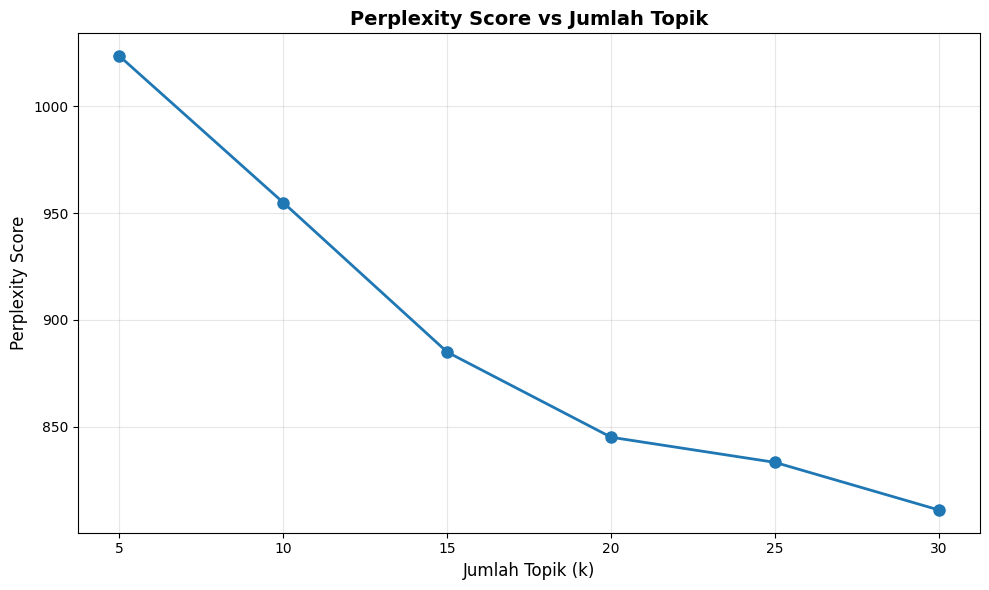


✓ Jumlah topik optimal (berdasarkan perplexity): 30


In [13]:
# Visualisasi Perplexity Score
plt.figure(figsize=(10, 6))
plt.plot(topic_range, perplexity_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Jumlah Topik (k)', fontsize=12)
plt.ylabel('Perplexity Score', fontsize=12)
plt.title('Perplexity Score vs Jumlah Topik', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(topic_range)
plt.tight_layout()
plt.show()

# Pilih jumlah topik dengan perplexity terendah
optimal_topics = topic_range[np.argmin(perplexity_scores)]
print(f"\n✓ Jumlah topik optimal (berdasarkan perplexity): {optimal_topics}")

### 4.3 Melatih Model LDA dengan Jumlah Topik Optimal

In [14]:
# Latih model LDA final dengan jumlah topik optimal
print("="*50)
print(f"MELATIH MODEL LDA DENGAN {optimal_topics} TOPIK")
print("="*50)

lda_model = LatentDirichletAllocation(
    n_components=optimal_topics,
    random_state=0,
    max_iter=1000,  # Lebih banyak iterasi untuk model final
    learning_method='batch',
    n_jobs=-1,
    verbose=1
)

# Fit model LDA pada data training
lda_model.fit(X_train_counts)

print(f"\n✓ Model LDA berhasil dilatih dengan {optimal_topics} topik")

MELATIH MODEL LDA DENGAN 30 TOPIK
iteration: 1 of max_iter: 1000
iteration: 2 of max_iter: 1000
iteration: 3 of max_iter: 1000
iteration: 4 of max_iter: 1000
iteration: 5 of max_iter: 1000
iteration: 6 of max_iter: 1000
iteration: 7 of max_iter: 1000
iteration: 8 of max_iter: 1000
iteration: 9 of max_iter: 1000
iteration: 10 of max_iter: 1000
iteration: 11 of max_iter: 1000
iteration: 12 of max_iter: 1000
iteration: 13 of max_iter: 1000
iteration: 14 of max_iter: 1000
iteration: 15 of max_iter: 1000
iteration: 16 of max_iter: 1000
iteration: 17 of max_iter: 1000
iteration: 18 of max_iter: 1000
iteration: 19 of max_iter: 1000
iteration: 20 of max_iter: 1000
iteration: 21 of max_iter: 1000
iteration: 22 of max_iter: 1000
iteration: 23 of max_iter: 1000
iteration: 24 of max_iter: 1000
iteration: 25 of max_iter: 1000
iteration: 26 of max_iter: 1000
iteration: 27 of max_iter: 1000
iteration: 28 of max_iter: 1000
iteration: 29 of max_iter: 1000
iteration: 30 of max_iter: 1000
iteration: 31 o

In [15]:
# Tampilkan top words untuk setiap topik
def display_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append((topic_idx, top_words))
    return topics

# Get feature names dari vectorizer
feature_names = vectorizer.get_feature_names_out()

# Tampilkan topik-topik
print("="*50)
print("TOP 10 KATA PER TOPIK")
print("="*50)

topics = display_topics(lda_model, feature_names, n_top_words=10)
for topic_idx, top_words in topics:
    print(f"\nTopik {topic_idx}:")
    print(", ".join(top_words))

TOP 10 KATA PER TOPIK

Topik 0:
menteri, kerja, indonesia, usaha, pangan, bangun, dukung, perintah, tingkat, tani

Topik 1:
jalan, kendara, kereta, wib, arus, lintas, tol, nataru, motor, raya

Topik 2:
partai, jokowi, komisi, dpr, ketua, hadir, pdip, bumn, rapat, gelar

Topik 3:
gol, main, menit, indonesia, piala, aff, vietnam, laga, babak, tanding

Topik 4:
persen, rp, anggar, juta, triliun, prabowo, perintah, biaya, haji, belanja

Topik 5:
makan, gizi, program, gratis, mbg, jabat, dad, bgn, menu, angkat

Topik 6:
trump, as, presiden, amerika, serikat, greenland, negara, rusia, warga, jabat

Topik 7:
kerja, pensiun, semarang, kevin, gim, rekan, istora, belgia, suami, advokat

Topik 8:
orang, tembak, rumah, korban, warga, luka, mobil, tewas, sakit, malaysia

Topik 9:
indonesia, timnas, latih, main, piala, kluivert, pssi, dunia, erick, tim

Topik 10:
gunung, erupsi, umkm, sekolah, puncak, sungai, amat, meru, timur, pusat

Topik 11:
israel, gaza, senjata, gencat, hamas, palestina, sander

### 4.4 Ekstraksi Fitur: Transformasi Dokumen ke Distribusi Topik (θ)

In [16]:
# Transform dokumen menjadi distribusi topik
# Setiap dokumen akan direpresentasikan sebagai vektor probabilitas topik
X_train_lda = lda_model.transform(X_train_counts)
X_test_lda = lda_model.transform(X_test_counts)

print("="*50)
print("EKSTRAKSI FITUR LDA")
print("="*50)
print(f"Bentuk fitur LDA training: {X_train_lda.shape}")
print(f"Bentuk fitur LDA testing: {X_test_lda.shape}")
print(f"\nSetiap dokumen kini direpresentasikan sebagai vektor dengan {optimal_topics} dimensi")
print("(probabilitas dokumen terkait dengan setiap topik)")

# Contoh distribusi topik untuk dokumen pertama
print(f"\n" + "="*50)
print("CONTOH DISTRIBUSI TOPIK DOKUMEN PERTAMA")
print("="*50)
for i, prob in enumerate(X_train_lda[0]):
    print(f"Topik {i}: {prob:.4f}")
    
print(f"\nTotal probabilitas: {X_train_lda[0].sum():.4f} (harus = 1.0)")

EKSTRAKSI FITUR LDA
Bentuk fitur LDA training: (1200, 30)
Bentuk fitur LDA testing: (300, 30)

Setiap dokumen kini direpresentasikan sebagai vektor dengan 30 dimensi
(probabilitas dokumen terkait dengan setiap topik)

CONTOH DISTRIBUSI TOPIK DOKUMEN PERTAMA
Topik 0: 0.0003
Topik 1: 0.0336
Topik 2: 0.0003
Topik 3: 0.0003
Topik 4: 0.0003
Topik 5: 0.0003
Topik 6: 0.0003
Topik 7: 0.0003
Topik 8: 0.4199
Topik 9: 0.0003
Topik 10: 0.0003
Topik 11: 0.0003
Topik 12: 0.0003
Topik 13: 0.0003
Topik 14: 0.1656
Topik 15: 0.0003
Topik 16: 0.2915
Topik 17: 0.0003
Topik 18: 0.0003
Topik 19: 0.0003
Topik 20: 0.0003
Topik 21: 0.0003
Topik 22: 0.0003
Topik 23: 0.0003
Topik 24: 0.0152
Topik 25: 0.0003
Topik 26: 0.0003
Topik 27: 0.0003
Topik 28: 0.0003
Topik 29: 0.0668

Total probabilitas: 1.0000 (harus = 1.0)


## 5. Pelatihan Model Klasifikasi (SVM)
Melatih SVM menggunakan fitur LDA yang sudah diekstraksi.

In [17]:
# Latih SVM dengan fitur LDA
print("="*50)
print("MELATIH MODEL SVM DENGAN FITUR LDA")
print("="*50)

svm_lda = SVC(kernel='rbf', random_state=42, verbose=True)
svm_lda.fit(X_train_lda, y_train)

print("\n✓ Model SVM berhasil dilatih dengan fitur LDA")

MELATIH MODEL SVM DENGAN FITUR LDA
[LibSVM]
✓ Model SVM berhasil dilatih dengan fitur LDA


In [18]:
# Prediksi pada data testing
y_pred_lda = svm_lda.predict(X_test_lda)

print("="*50)
print("PREDIKSI SELESAI")
print("="*50)
print(f"Jumlah prediksi: {len(y_pred_lda)}")
print(f"\nContoh 10 prediksi pertama:")
for i in range(10):
    print(f"Aktual: {y_test[i]:15} | Prediksi: {y_pred_lda[i]}")

PREDIKSI SELESAI
Jumlah prediksi: 300

Contoh 10 prediksi pertama:
Aktual: Internasional   | Prediksi: Internasional
Aktual: Internasional   | Prediksi: Internasional
Aktual: Olahraga        | Prediksi: Olahraga
Aktual: Olahraga        | Prediksi: Olahraga
Aktual: Olahraga        | Prediksi: Olahraga
Aktual: Nasional        | Prediksi: Nasional
Aktual: Olahraga        | Prediksi: Olahraga
Aktual: Ekonomi         | Prediksi: Ekonomi
Aktual: Internasional   | Prediksi: Internasional
Aktual: Olahraga        | Prediksi: Olahraga


### 5.1 Evaluasi Hasil Klasifikasi (LDA + SVM)

In [19]:
# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT (LDA + SVM)")
print("="*50)
print(classification_report(y_test, y_pred_lda, zero_division=0))


CLASSIFICATION REPORT (LDA + SVM)
               precision    recall  f1-score   support

      Ekonomi       0.82      0.96      0.88        75
Internasional       0.97      0.96      0.97        75
     Nasional       0.94      0.77      0.85        75
     Olahraga       0.99      1.00      0.99        75

     accuracy                           0.92       300
    macro avg       0.93      0.92      0.92       300
 weighted avg       0.93      0.92      0.92       300



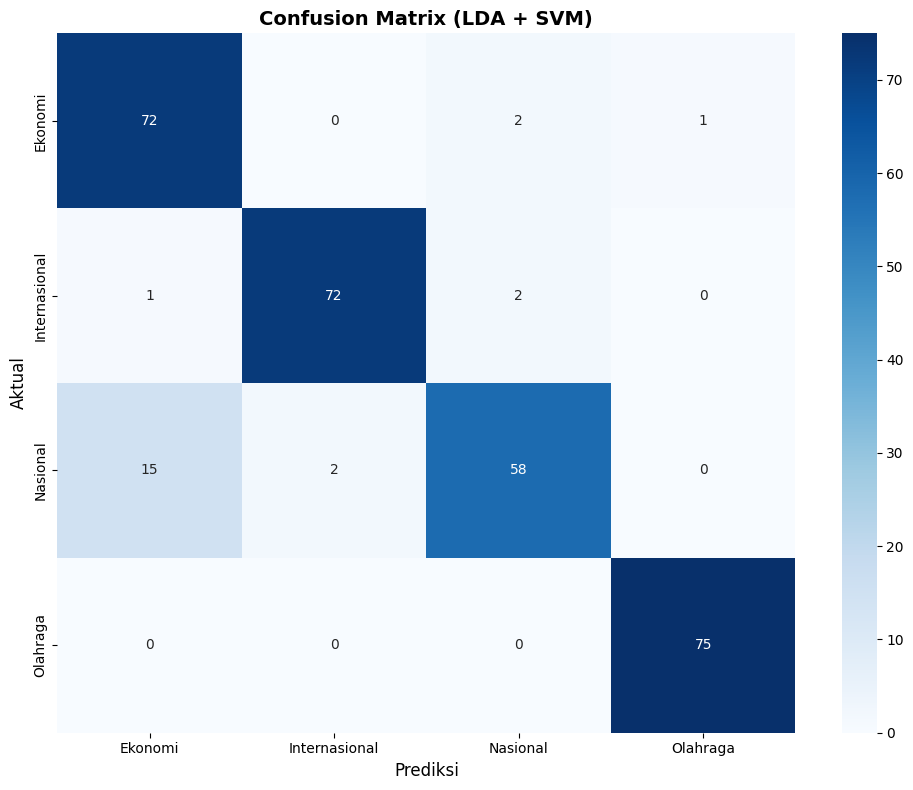

In [20]:
# Confusion Matrix
cm_lda = confusion_matrix(y_test, y_pred_lda)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(y_test)), 
            yticklabels=sorted(set(y_test)))
plt.title('Confusion Matrix (LDA + SVM)', fontsize=14, fontweight='bold')
plt.ylabel('Aktual', fontsize=12)
plt.xlabel('Prediksi', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Pelatihan Model Klasifikasi Alternatif (Naive Bayes)
Melatih Naive Bayes menggunakan fitur LDA yang sama untuk perbandingan.

In [21]:
# Import Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Latih Naive Bayes dengan fitur LDA
print("="*50)
print("MELATIH MODEL NAIVE BAYES DENGAN FITUR LDA")
print("="*50)

nb_lda = MultinomialNB()
nb_lda.fit(X_train_lda, y_train)

print("\n✓ Model Naive Bayes berhasil dilatih dengan fitur LDA")

MELATIH MODEL NAIVE BAYES DENGAN FITUR LDA

✓ Model Naive Bayes berhasil dilatih dengan fitur LDA


In [22]:
# Prediksi pada data testing dengan Naive Bayes
y_pred_nb = nb_lda.predict(X_test_lda)

print("="*50)
print("PREDIKSI NAIVE BAYES SELESAI")
print("="*50)
print(f"Jumlah prediksi: {len(y_pred_nb)}")
print(f"\nContoh 10 prediksi pertama:")
for i in range(10):
    print(f"Aktual: {y_test[i]:15} | Prediksi: {y_pred_nb[i]}")

PREDIKSI NAIVE BAYES SELESAI
Jumlah prediksi: 300

Contoh 10 prediksi pertama:
Aktual: Internasional   | Prediksi: Internasional
Aktual: Internasional   | Prediksi: Internasional
Aktual: Olahraga        | Prediksi: Olahraga
Aktual: Olahraga        | Prediksi: Olahraga
Aktual: Olahraga        | Prediksi: Olahraga
Aktual: Nasional        | Prediksi: Nasional
Aktual: Olahraga        | Prediksi: Olahraga
Aktual: Ekonomi         | Prediksi: Ekonomi
Aktual: Internasional   | Prediksi: Internasional
Aktual: Olahraga        | Prediksi: Olahraga


## 6.1. Evaluasi Hasil Klasifikasi (LDA + Naive Bayes)

In [23]:
# Classification Report untuk Naive Bayes
print("\n" + "="*50)
print("CLASSIFICATION REPORT (LDA + NAIVE BAYES)")
print("="*50)
print(classification_report(y_test, y_pred_nb, zero_division=0))


CLASSIFICATION REPORT (LDA + NAIVE BAYES)
               precision    recall  f1-score   support

      Ekonomi       0.84      0.97      0.90        75
Internasional       1.00      0.92      0.96        75
     Nasional       0.90      0.83      0.86        75
     Olahraga       1.00      1.00      1.00        75

     accuracy                           0.93       300
    macro avg       0.93      0.93      0.93       300
 weighted avg       0.93      0.93      0.93       300



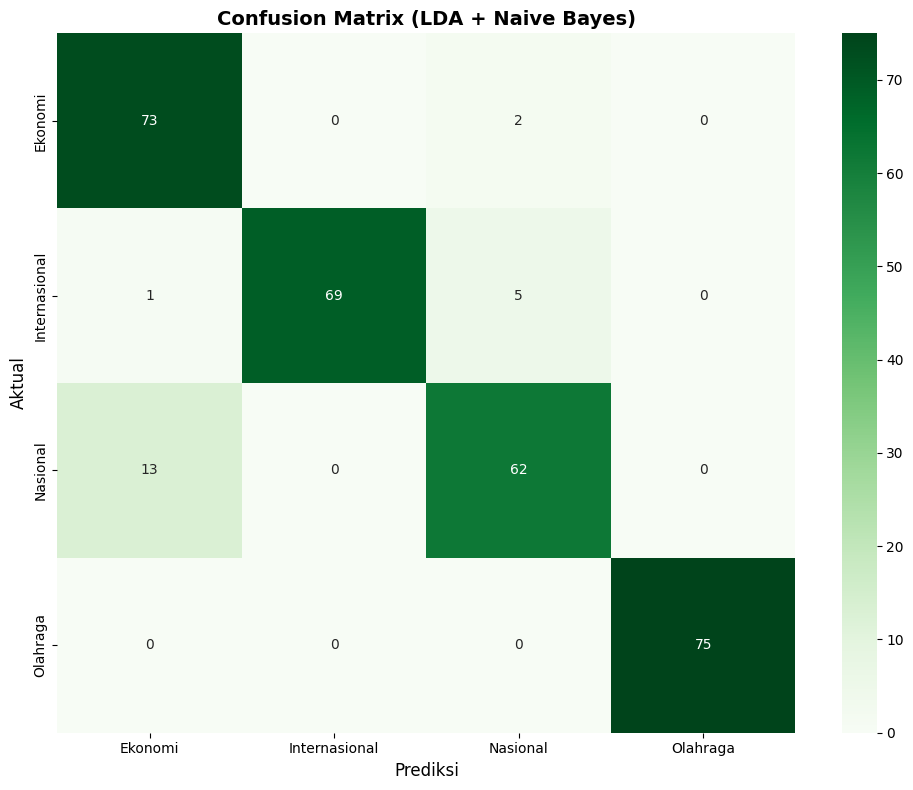

In [24]:
# Confusion Matrix untuk Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', 
            xticklabels=sorted(set(y_test)), 
            yticklabels=sorted(set(y_test)))
plt.title('Confusion Matrix (LDA + Naive Bayes)', fontsize=14, fontweight='bold')
plt.ylabel('Aktual', fontsize=12)
plt.xlabel('Prediksi', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Perbandingan Performa: LDA + SVM vs LDA + Naive Bayes

In [25]:
# Hitung metrik untuk kedua model
print("="*70)
print("PERBANDINGAN METRIK EVALUASI")
print("="*70)

# Metrik untuk SVM
accuracy_svm = accuracy_score(y_test, y_pred_lda)
precision_svm = precision_score(y_test, y_pred_lda, average='weighted', zero_division=0)
recall_svm = recall_score(y_test, y_pred_lda, average='weighted', zero_division=0)
f1_svm = f1_score(y_test, y_pred_lda, average='weighted', zero_division=0)

# Metrik untuk Naive Bayes
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted', zero_division=0)
recall_nb = recall_score(y_test, y_pred_nb, average='weighted', zero_division=0)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted', zero_division=0)

# Buat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    'Metrik': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'LDA + SVM': [accuracy_svm, precision_svm, recall_svm, f1_svm],
    'LDA + Naive Bayes': [accuracy_nb, precision_nb, recall_nb, f1_nb]
})

print(comparison_df.to_string(index=False))
print("="*70)

PERBANDINGAN METRIK EVALUASI
   Metrik  LDA + SVM  LDA + Naive Bayes
 Accuracy   0.923333           0.930000
Precision   0.928370           0.934408
   Recall   0.923333           0.930000
 F1-Score   0.922493           0.930170


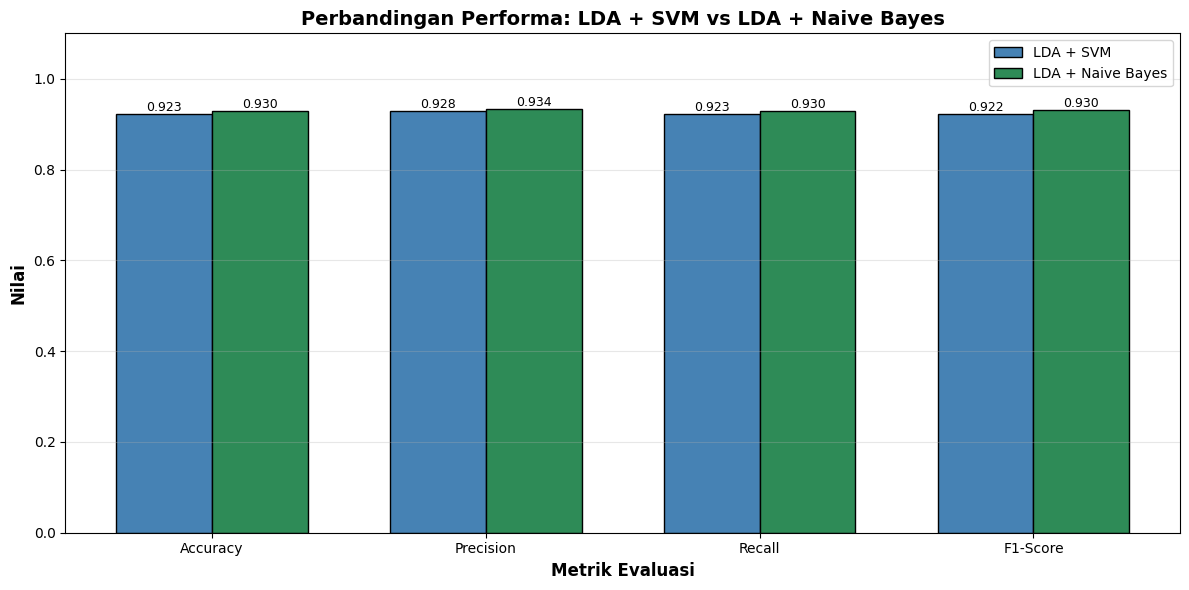

In [26]:
# Visualisasi perbandingan metrik
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df['Metrik']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['LDA + SVM'], width, 
               label='LDA + SVM', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, comparison_df['LDA + Naive Bayes'], width, 
               label='LDA + Naive Bayes', color='seagreen', edgecolor='black')

ax.set_xlabel('Metrik Evaluasi', fontsize=12, fontweight='bold')
ax.set_ylabel('Nilai', fontsize=12, fontweight='bold')
ax.set_title('Perbandingan Performa: LDA + SVM vs LDA + Naive Bayes', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metrik'])
ax.legend(fontsize=10)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Tambahkan nilai di atas bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()